In [1]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "vscode"
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, explode, col, regexp_replace, transform, isnan

spark = SparkSession.builder.appName("LightcastCleanedData").getOrCreate()

# 重新加载处理后的数据
df_cleaned = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").csv("data/lightcast_cleaned.csv")

# 查看数据结构和样本
df_cleaned.show()

your 131072x1 screen size is bogus. expect trouble
25/04/19 22:42:40 WARN Utils: Your hostname, DESKTOP-AEE21PF resolves to a loopback address: 127.0.1.1; using 192.168.167.208 instead (on interface eth0)
25/04/19 22:42:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/19 22:42:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/19 22:42:46 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-------------------+----------------------+----------+----------+----------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+---------+--------------------+--------------------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+------------------+------+--------------------+-----+--------------------+-----+-------------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+-----

In [ ]:
df_cleaned.select("TITLE_RAW").distinct().show(10, False)

30346

In [8]:
from pyspark.sql.functions import col, when
# Create a new column EDU_MATCH, mark it as a match or not
df_compare = df_cleaned.withColumn(
    "EDU_MATCH",
    when(col("ONET") == col("ONET_2019"), "Match").otherwise("Mismatch")
)

df_compare.select("ONET", "ONET_2019", "EDU_MATCH").show(truncate=False)

# 统计不匹配的行数
unmatched_count = df_cleaned.filter(col("MIN_EDULEVELS") != col("EDUCATION_LEVELS")).count()
print(f"Not Match: {unmatched_count}")

+----------+----------+---------+
|ONET      |ONET_2019 |EDU_MATCH|
+----------+----------+---------+
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
+----------+----------+---------+
only showing top 20 rows



Not Match: 0


In [9]:
from pyspark.sql.functions import col, when
# Create a new column EDU_MATCH, mark it as a match or not
df_compare = df_cleaned.withColumn(
    "EDU_MATCH",
    when(col("ONET_NAME") == col("ONET_2019_NAME"), "Match").otherwise("Mismatch")
)

df_compare.select("ONET_NAME", "ONET_2019_NAME", "EDU_MATCH").show(truncate=False)

# 统计不匹配的行数
unmatched_count = df_cleaned.filter(col("MIN_EDULEVELS") != col("EDUCATION_LEVELS")).count()
print(f"Not Match: {unmatched_count}")

+------------------------------+------------------------------+---------+
|ONET_NAME                     |ONET_2019_NAME                |EDU_MATCH|
+------------------------------+------------------------------+---------+
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Busine

Not Match: 0


k = 2, SSE = 1666759.21


k = 3, SSE = 1635634.26


k = 4, SSE = 1610361.03


k = 5, SSE = 1565495.99


k = 6, SSE = 1539833.74


k = 7, SSE = 1526481.66


k = 8, SSE = 1488706.26


k = 9, SSE = 1460572.26


k = 10, SSE = 1433578.97


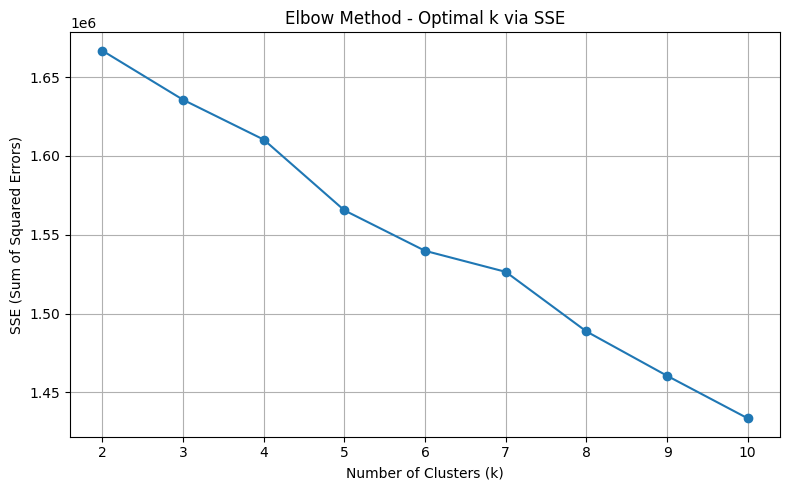

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt

# === 选择用于聚类的字段 ===
numeric_cols = ["DURATION", "SALARY"]
categorical_cols = ["EDUCATION_LEVELS", "EMPLOYMENT_TYPE", "REMOTE_TYPE", "STATE"]

df_kmeans = df_cleaned.select(numeric_cols + categorical_cols).dropna()

# === 类型转换 ===
for col_name in numeric_cols:
    df_kmeans = df_kmeans.withColumn(col_name, col(col_name).cast(DoubleType()))

# === 处理分类变量 ===
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid='skip') for c in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{c}_idx", outputCol=f"{c}_vec") for c in categorical_cols]
encoded_categorical = [f"{c}_vec" for c in categorical_cols]

# === 特征组合 ===
assembler = VectorAssembler(
    inputCols=numeric_cols + encoded_categorical,
    outputCol="raw_features"
)

# === 标准化 ===
scaler = StandardScaler(inputCol="raw_features", outputCol="features", withStd=True, withMean=True)

# === 遍历不同 k 值，计算 SSE ===
cost = []  # 用于存储 k 和对应的 SSE 值
for k in range(2, 11):  # k 从 2 到 10
    kmeans = KMeans(k=k, seed=688, featuresCol="features")
    pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler, kmeans])
    
    # 拟合模型
    model_kmeans = pipeline.fit(df_kmeans)
    
    # 获取 KMeans 聚类模型阶段（Pipeline 的最后一个 stage）
    kmeans_data = model_kmeans.stages[-1]
    sse = kmeans_data.summary.trainingCost  # 获取 SSE 值
    cost.append((k, sse))  # 存储 k 和 SSE
    print(f"k = {k}, SSE = {sse:.2f}")

# === 绘制 Elbow 图 ===
k_vals, sse_vals = zip(*cost)  # 解包 k 和 SSE
plt.figure(figsize=(8, 5))
plt.plot(k_vals, sse_vals, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("SSE (Sum of Squared Errors)")
plt.title("Elbow Method - Optimal k via SSE")
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

k = 5 # 你可以根据 Elbow 图选择最优 k
kmeans = KMeans(k=k, seed=688, featuresCol="features")
pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler, kmeans])
model = pipeline.fit(df_kmeans)

# 获取聚类结果并保留 EMPLOYMENT_TYPE 和 prediction（聚类标签）
clustered_df = model.transform(df_kmeans).select("EMPLOYMENT_TYPE", "prediction")

# === 转换为 Pandas，用于 sklearn 评估 ===
pandas_df = clustered_df.toPandas()

# 标签编码
le = LabelEncoder()
true_labels = le.fit_transform(pandas_df["EMPLOYMENT_TYPE"])
predicted_labels = pandas_df["prediction"]

# 计算评估指标
nmi = normalized_mutual_info_score(true_labels, predicted_labels)
ari = adjusted_rand_score(true_labels, predicted_labels)


print(f"NMI: {nmi:.4f}")
print(f"ARI: {ari:.4f}")



NMI: 0.0113
ARI: 0.0332


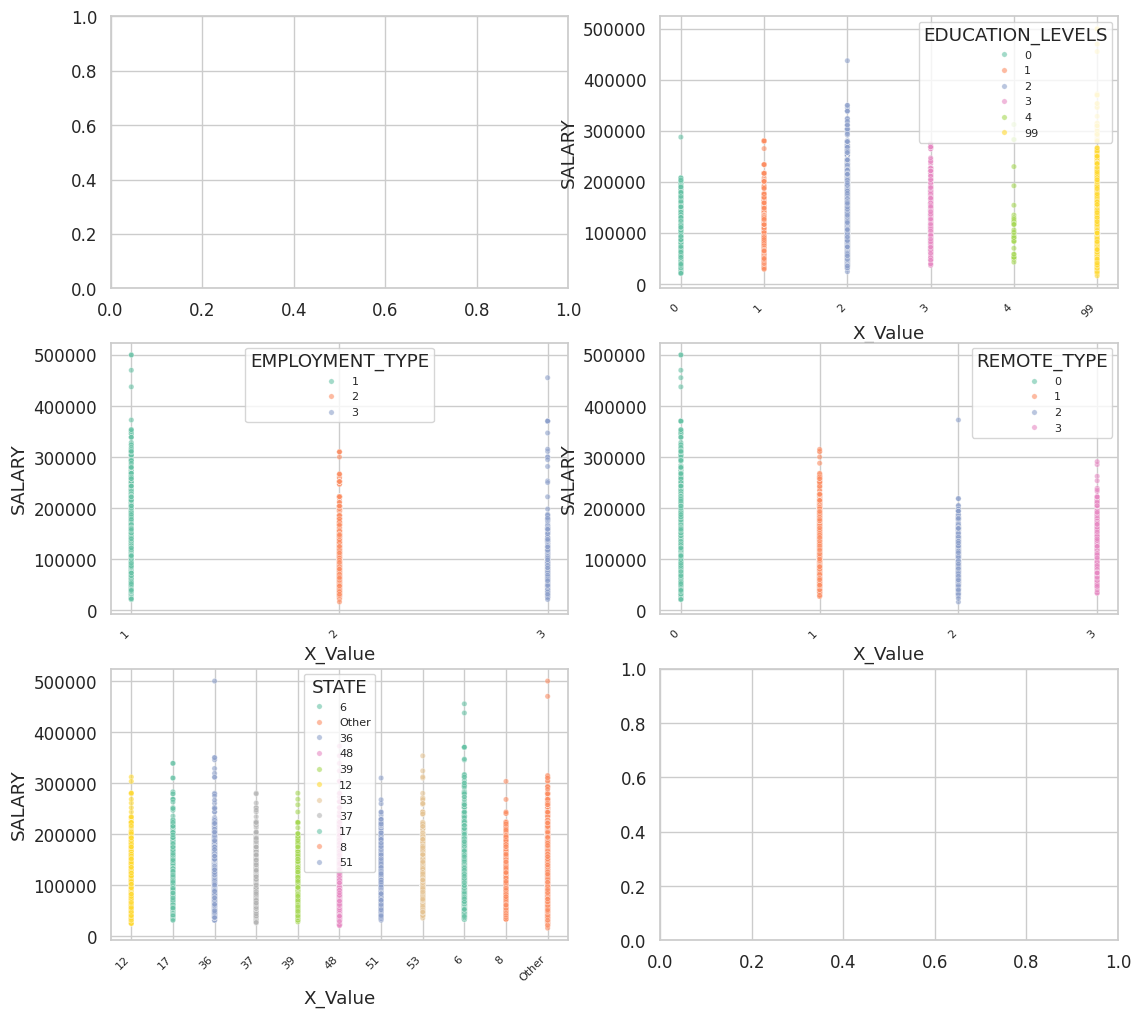

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Step 1: 从 Spark 转换为 pandas
selected_cols = ["SALARY", "DURATION", "EDUCATION_LEVELS", "EMPLOYMENT_TYPE", "REMOTE_TYPE", "STATE"]
df_viz = df_cleaned.select(selected_cols).dropna().toPandas()

# Step 2: 限制 STATE 分类数量
top_states = df_viz["STATE"].value_counts().nlargest(10).index
df_viz["STATE"] = df_viz["STATE"].where(df_viz["STATE"].isin(top_states), other="Other")

# Step 3: 构建变量与 SALARY 的散点图数据列表
feature_plots = [
    ("DURATION", False), # 数值型变量，不需要 LabelEncoder
    ("EDUCATION_LEVELS", True),
    ("EMPLOYMENT_TYPE", True),
    ("REMOTE_TYPE", True),
    ("STATE", True)
]

plot_data_list = []
label_encoders = {}

for feature, is_categorical in feature_plots:
    df_temp = df_viz[[feature, "SALARY"]].dropna().copy()
    df_temp["Feature"] = feature
    if is_categorical:
        le = LabelEncoder()
        df_temp["X_Value"] = le.fit_transform(df_temp[feature].astype(str))
        df_temp["Hue_Label"] = df_temp[feature]  # 保留原始标签用于 hue
        label_encoders[feature] = le
    else:
        df_temp["X_Value"] = df_temp[feature]
        df_temp["Hue_Label"] = None  # 没有分类标签

    plot_data_list.append(df_temp[["Feature", "X_Value", "SALARY", "Hue_Label"]])

# 合并所有数据
df_long = pd.concat(plot_data_list, ignore_index=True)

# Step 4: 使用 matplotlib 手动分面 + 每图独立 hue + legend
sns.set(style="whitegrid", font_scale=1.1)

# 分面图设置
n_cols = 2
fig, axes = plt.subplots(nrows=3, ncols=n_cols, figsize=(13, 12))
axes = axes.flatten()

# 每个图一个子集
for i, (feature, is_cat) in enumerate(feature_plots):
    ax = axes[i]
    data = df_long[df_long["Feature"] == feature]

    if is_cat:
        sns.scatterplot(data=data, x="X_Value", y="SALARY", hue="Hue_Label", ax=ax, s=15, alpha=0.6, palette="Set2")
        le = label_encoders[feature]
        ax.set_xticks(range(len(le.classes_)))
        ax.set_xticklabels(le.classes_, rotation=45, ha='right', fontsize=8)
        ax.legend(title=feature, loc='best', fontsize=8)
 

In [3]:
# ===== 多元线性回归（标准化版本）=====
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import DoubleType

# 选择字段
lr_df = df_cleaned.select(
    "DURATION", "EDUCATION_LEVELS", "SALARY", "SALARY_FROM", "SALARY_TO"
).dropna()

# 类型转换
num_cols = ["DURATION", "EDUCATION_LEVELS", "SALARY", "SALARY_FROM", "SALARY_TO"]
for col_name in num_cols:
    lr_df = lr_df.withColumn(col_name, col(col_name).cast(DoubleType()))

# 拼接特征向量
assembler = VectorAssembler(
    inputCols=["DURATION", "EDUCATION_LEVELS", "SALARY_FROM", "SALARY_TO"],
    outputCol="assembled_features"
)

# 标准化
scaler = StandardScaler(inputCol="assembled_features", outputCol="features")

# 模型
lr = LinearRegression(featuresCol="features", labelCol="SALARY")

# 划分训练测试集
train_data, test_data = lr_df.randomSplit([0.8, 0.2], seed=42)
train_data = train_data.na.drop(subset=num_cols)
test_data = test_data.na.drop(subset=num_cols)

pipeline = Pipeline(stages=[assembler, scaler, lr])
model = pipeline.fit(train_data)
predictions = model.transform(test_data)

# 评估
evaluator_r2 = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="rmse")

r2 = evaluator_r2.evaluate(predictions)
rmse = evaluator_rmse.evaluate(predictions)

print("\n✅ 多元线性回归结果:")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")


25/04/19 20:42:57 WARN Instrumentation: [c0826b6d] regParam is zero, which might cause numerical instability and overfitting.



✅ 多元线性回归结果:
R²: 0.9991
RMSE: 1340.99
